## **Import the necessary libraries**

In [3]:
import pandas as pd                                 # Importing pandas
import numpy as np                                  # Importing numpy
import matplotlib.pyplot as plt                     # Importing matplotlib for visualization

%matplotlib inline                      
import seaborn as sns                               # Importing seaborn for visualization

import matplotlib.ticker as ticker
import matplotlib.cm as cm
# import plotly_express as px  #visualisation
# import pandas_profiling                             # AUtomatic EDA

from scipy.stats import skew, kurtosis
import calendar
from math import radians, cos, sin, asin, sqrt      # to calculate great circle distance

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **1) Data loading using Pandas**

In [0]:
# read the NYC_Taxi dataset 
import pandas as pd
#df_nyc_taxi = pd.read_csv("train.csv",  parse_dates=True)
df_nyc_taxi = pd.read_csv("/content/drive/My Drive/datasets/train.csv",  parse_dates=True)

In [51]:
df_nyc_taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## **2) Indentify unique business problems and provide visualizations**

### **a) data understanding**

In [52]:
df_nyc_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [53]:
df_nyc_taxi.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

No null values present in the dataset. 

In [54]:
df_nyc_taxi.describe()                                             # 5 point summary of numerical attributes

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


The **passenger_count** and the **trip_duration** features seems to be having a skewed distribution(right skewed) as the mean is very high compared to the median. <br>

In [55]:
df_nyc_taxi['trip_duration'].describe(percentiles=[.25, .5, .75, .9, .95, .99, .999])

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
90%      1.634000e+03
95%      2.104000e+03
99%      3.440000e+03
99.9%    8.512836e+04
max      3.526282e+06
Name: trip_duration, dtype: float64

There are lots of outliers in this feature. The **mean is 959 seconds, median is 662 seconds (distribution is right skewed)** <br>
**The 99th percentile value is 3440 seconds which is way less than the 99.9th percentile value of 85128 seconds.**

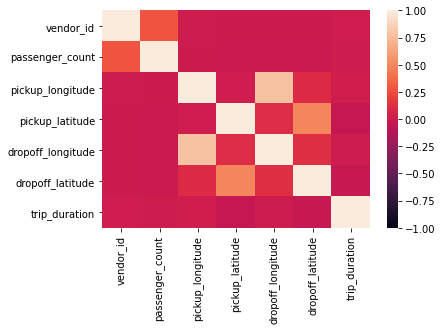

In [56]:
correlation = df_nyc_taxi[['vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration']].corr()
sns.heatmap(correlation, vmin = -1, vmax = 1) 

In [57]:
df_nyc_taxi.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [58]:
df_nyc_taxi.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

There are only 2 types of vendors and the number of passengers range from 0-9

### **a) data cleaning**

In [59]:
df_nyc_taxi.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

No null values in the dataset.

### **Transform the 'trip_duration' feature from seconds to minutes for ease of plotting**

In [0]:
df_nyc_taxi['trip_duration_minutes'] = df_nyc_taxi['trip_duration']/60

### **Lets's create custom features for the dataset**

There isnt any feature which seems to be having a linear relation with output variable. So, lets create one!

#### **Calculate Distance**

We can calculate the great circle distance or the orthodromic distance which is the shortest distance between two points on a sphere (or the surface of Earth).

In [6]:
def distance(lon1, lat1, lon2, lat2): 
      
    # The math module contains a function named 
    # radians which converts from degrees to radians. 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
     
    # Radius of earth in kilometers. Use 3956 for miles 
    r = 6371
       
    # calculate the result 
    return(c * r) 

# driver code  
lat1 = 40.767937
lat2 = 40.765602
lon1 = -73.982155
lon2 =  -73.964630
print(distance(lon1, lat1, lon2, lat2), "K.M") 

1.4985518720659607 K.M


In [0]:
df_nyc_taxi['distance'] = df_nyc_taxi.apply(lambda x: distance(x['pickup_longitude'],x['pickup_latitude'],x['dropoff_longitude'],x['dropoff_latitude']), axis = 1)

In [63]:
df_nyc_taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_minutes,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,7.583333,1.498521
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,11.050000,1.805507
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,35.400000,6.385098
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,7.150000,1.485498
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,7.250000,1.188588


#### **Calculate speed**

In [0]:
df_nyc_taxi['speed']= (df_nyc_taxi.distance/(df_nyc_taxi.trip_duration/3600))

In [65]:
df_nyc_taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_minutes,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,7.583333,1.498521,11.856428
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,11.050000,1.805507,9.803659
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,35.400000,6.385098,10.822201
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,7.150000,1.485498,12.465721
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,7.250000,1.188588,9.836594


#### **Create month, day, hour features for pickup**

In [0]:
df_nyc_taxi['pickup_month'] = pd.DatetimeIndex(df_nyc_taxi['pickup_datetime']).month            # add month columns

In [0]:
df_nyc_taxi['pickup_day'] = pd.DatetimeIndex(df_nyc_taxi['pickup_datetime']).day                # add day columns

In [0]:
df_nyc_taxi['pickup_hour'] = pd.DatetimeIndex(df_nyc_taxi['pickup_datetime']).hour            # add hour columns

In [0]:
# The day of the week with Monday=0, Sunday=6.
df_nyc_taxi['pickup_day_of_week'] = pd.DatetimeIndex(df_nyc_taxi['pickup_datetime']).dayofweek  # add dayofweek columns

In [0]:
df_nyc_taxi['drop_month'] = pd.DatetimeIndex(df_nyc_taxi['dropoff_datetime']).month            # add month columns

In [0]:
df_nyc_taxi['drop_day'] = pd.DatetimeIndex(df_nyc_taxi['dropoff_datetime']).day                # add day columns

In [0]:
df_nyc_taxi['drop_hour'] = pd.DatetimeIndex(df_nyc_taxi['dropoff_datetime']).day                # add hour columns

In [0]:
# The day of the week with Monday=0, Sunday=6.
df_nyc_taxi['drop_day_of_week'] = pd.DatetimeIndex(df_nyc_taxi['dropoff_datetime']).dayofweek  # add dayofweek columns

In [74]:
df_nyc_taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_minutes,distance,speed,pickup_month,pickup_day,pickup_hour,pickup_day_of_week,drop_month,drop_day,drop_hour,drop_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,7.583333,1.498521,11.856428,3,14,17,0,3,14,14,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,11.050000,1.805507,9.803659,6,12,0,6,6,12,12,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,35.400000,6.385098,10.822201,1,19,11,1,1,19,19,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,7.150000,1.485498,12.465721,4,6,19,2,4,6,6,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,7.250000,1.188588,9.836594,3,26,13,5,3,26,26,5


Lets statistically analyse the columns again.

In [75]:
df_nyc_taxi.describe() 

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,trip_duration_minutes,distance,speed,pickup_month,pickup_day,pickup_hour,pickup_day_of_week,drop_month,drop_day,drop_hour,drop_day_of_week
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,1.599154e+01,3.440864e+00,1.442321e+01,3.516818e+00,1.550402e+01,1.360648e+01,3.050375e+00,3.517178e+00,1.550448e+01,1.550448e+01,3.054422e+00
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,8.729053e+01,4.296538e+00,1.497752e+01,1.681038e+00,8.703135e+00,6.399693e+00,1.954039e+00,1.681217e+00,8.703123e+00,8.703123e+00,1.956599e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,1.666667e-02,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,6.616667e+00,1.231837e+00,9.121275e+00,2.000000e+00,8.000000e+00,9.000000e+00,1.000000e+00,2.000000e+00,8.000000e+00,8.000000e+00,1.000000e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,1.103333e+01,2.093717e+00,1.279198e+01,4.000000e+00,1.500000e+01,1.400000e+01,3.000000e+00,4.000000e+00,1.500000e+01,1.500000e+01,3.000000e+00
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,1.791667e+01,3.875337e+00,1.784491e+01,5.000000e+00,2.300000e+01,1.900000e+01,5.000000e+00,5.000000e+00,2.300000e+01,2.300000e+01,5.000000e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,5.877137e+04,1.240909e+03,9.274837e+03,6.000000e+00,3.100000e+01,2.300000e+01,6.000000e+00,7.000000e+00,3.100000e+01,3.100000e+01,6.000000e+00


In [76]:
df_nyc_taxi.shape

(1458644, 22)

### **Distribution for distance feature.**

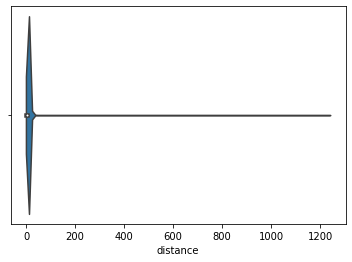

In [77]:
sns.violinplot(x='distance', data = df_nyc_taxi)

In [78]:
df_nyc_taxi[df_nyc_taxi.distance > 100]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_minutes,distance,speed,pickup_month,pickup_day,pickup_hour,pickup_day_of_week,drop_month,drop_day,drop_hour,drop_day_of_week
14502,id1092161,1,2016-04-15 22:35:08,2016-04-16 00:34:21,1,-73.781792,40.644718,-72.711395,41.311520,N,7153,119.216667,116.496424,58.630942,4,15,22,4,4,16,16,5
114376,id1311087,1,2016-02-29 12:16:29,2016-02-29 18:47:09,3,-75.455917,39.803932,-73.796021,40.707726,N,23440,390.666667,173.029358,26.574475,2,29,12,0,2,29,29,0
184925,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.809669,51.881084,-73.987228,40.750599,N,792,13.200000,1240.908677,5640.493985,5,7,18,5,5,7,7,5
275644,id0978162,1,2016-02-24 16:20:59,2016-02-24 16:35:34,4,-75.354332,34.712234,-73.834923,32.181141,N,875,14.583333,314.764203,1295.029865,2,24,16,2,2,24,24,2
283102,id2778014,2,2016-01-17 16:43:09,2016-01-17 16:50:16,1,-73.997086,40.728924,-72.671150,40.614220,N,427,7.116667,112.548872,948.889784,1,17,16,6,1,17,17,6
377068,id0116374,1,2016-04-02 20:33:19,2016-04-02 20:38:01,1,-74.007095,40.717113,-76.963242,38.946033,N,282,4.700000,320.125775,4086.712020,4,2,20,5,4,2,2,5
397526,id0982904,1,2016-04-28 13:32:14,2016-04-28 14:14:09,2,-73.870682,40.773598,-79.817978,38.963852,N,2515,41.916667,545.853499,781.340992,4,28,13,3,4,28,28,3
512980,id2066082,1,2016-01-25 23:53:17,2016-01-26 01:25:46,1,-73.877716,40.772167,-72.905891,41.319832,N,5549,92.483333,101.736296,66.003003,1,25,23,0,1,26,26,1
595540,id1723416,1,2016-03-20 21:07:56,2016-03-20 21:12:35,1,-78.547401,40.817131,-79.786133,40.917637,N,279,4.650000,104.759971,1351.741558,3,20,21,6,3,20,20,6
644165,id0401529,2,2016-06-02 15:19:35,2016-06-02 15:32:59,1,-73.980751,40.757111,-74.240051,38.478298,N,804,13.400000,254.363523,1138.941146,6,2,15,3,6,2,2,3


There are many trips with long distances. We can consider them as outliers and drop them

In [0]:
df_nyc_taxi = df_nyc_taxi[df_nyc_taxi.distance < 100]

The **speed** columns is having a maximun value of 5640 km/hr which is too fast. lets analyse this sample.

In [80]:
# find all trips with speed greater than 200 km/hr
df_nyc_taxi_speed_outlier = df_nyc_taxi[df_nyc_taxi.speed > 150]
df_nyc_taxi_speed_outlier

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_minutes,distance,speed,pickup_month,pickup_day,pickup_hour,pickup_day_of_week,drop_month,drop_day,drop_hour,drop_day_of_week
1107,id0729156,2,2016-06-23 13:36:48,2016-06-23 13:36:50,3,-73.827660,40.716175,-73.822113,40.711452,N,2,0.033333,0.703065,1265.516683,6,23,13,3,6,23,23,3
13046,id3468323,1,2016-06-27 18:37:21,2016-06-27 18:43:16,1,-73.881195,40.882942,-73.965141,40.762486,N,355,5.916667,15.142631,153.559078,6,27,18,0,6,27,27,0
107171,id1656254,2,2016-01-18 00:35:38,2016-01-18 00:35:54,1,-73.805527,40.651360,-73.804230,40.661629,N,16,0.266667,1.147109,258.099434,1,18,0,0,1,18,18,0
125668,id0456393,1,2016-04-27 06:59:15,2016-04-27 07:03:40,1,-73.979668,40.748005,-73.865097,40.683315,N,265,4.416667,12.040846,163.573763,4,27,6,2,4,27,27,2
127613,id1322914,2,2016-03-25 17:21:18,2016-03-25 17:21:27,1,-73.801102,40.669941,-73.801392,40.673851,N,9,0.150000,0.435466,174.186529,3,25,17,4,3,25,25,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359910,id3628988,1,2016-05-05 18:21:37,2016-05-05 18:30:45,1,-79.569733,41.586273,-80.355431,42.090183,N,548,9.133333,85.884876,564.207216,5,5,18,3,5,5,5,3
1370617,id2427976,2,2016-02-07 15:00:04,2016-02-07 15:00:11,1,-73.983749,40.755661,-73.981155,40.753223,N,7,0.116667,0.348149,179.048050,2,7,15,6,2,7,7,6
1390507,id3141426,2,2016-05-06 18:29:00,2016-05-06 18:29:05,1,-73.874718,40.730610,-73.867432,40.732868,N,5,0.083333,0.663298,477.574860,5,6,18,4,5,6,6,4
1398157,id2905190,2,2016-03-05 00:17:29,2016-03-05 00:17:32,1,-74.003487,40.732609,-74.004189,40.731274,N,3,0.050000,0.159808,191.769583,3,5,0,5,3,5,5,5


**All the above samples seems to be having wrong data (ie, wrong latitudes and longitudes). Some of the sources (lat,lon) are in the sea ! (source: Google maps)** <br>
Lets discard this data.

### **Remove outliers using 'speed' column**

In [18]:
df_nyc_taxi = df_nyc_taxi[df_nyc_taxi.speed < 120]
df_nyc_taxi.shape

(1458502, 22)

### **Remove outliers using 'trip_duration_minutes' or 'trip_duration' columns**

In [0]:
# drop rows having trip_duration more than 1 hour and less than 2 minutes
df_nyc_taxi = df_nyc_taxi[(df_nyc_taxi['trip_duration_minutes'] < 60) & (df_nyc_taxi['trip_duration_minutes'] > 2)]
#df_nyc_taxi = df_nyc_taxi[(df_nyc_taxi['trip_duration'] < 3600) & (df_nyc_taxi['trip_duration'] > 120)]

### **b) Data visualization**

#### **1) Correlation**

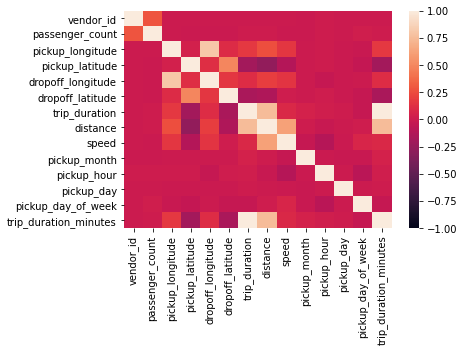

In [83]:
correlation = df_nyc_taxi[['vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance', 'speed', 'pickup_month', 'pickup_hour',
       'pickup_day', 'pickup_day_of_week', 'trip_duration_minutes']].corr()
sns.heatmap(correlation, vmin = -1, vmax = 1) 

### **2) Distribution plots**

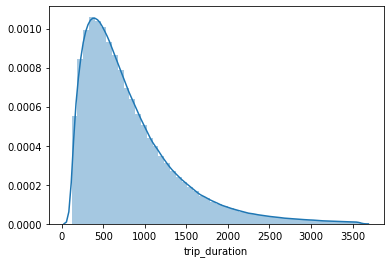

In [84]:
sns.distplot(df_nyc_taxi['trip_duration'])                    # distribution for 'trip_duration'

data is right skewed

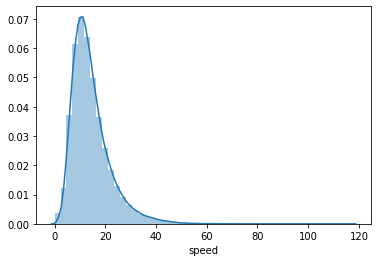

In [85]:
sns.distplot(df_nyc_taxi['speed'])                    # distribution for 'speed'

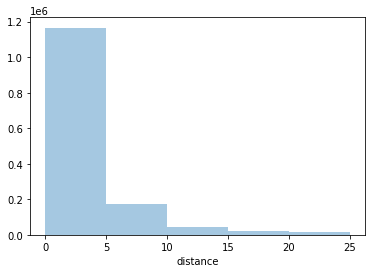

In [86]:
sns.distplot(df_nyc_taxi['distance'], bins=[0,5,10,15,20,25], kde=False)                    # distribution for 'distance'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f52cba537b8>,
      dtype=object)

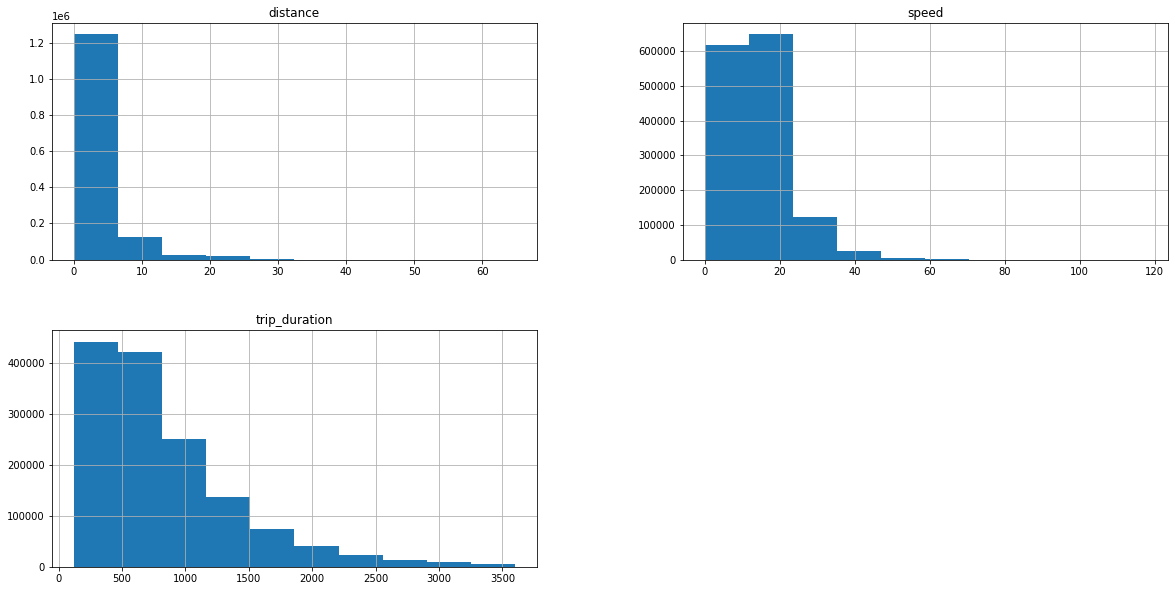

In [87]:
df_nyc_taxi.hist(column=['trip_duration', 'speed', 'distance'], figsize=(20,10))   

### **3) Bivariate analysis**

###**Does the speed increases as the distance increases ?**

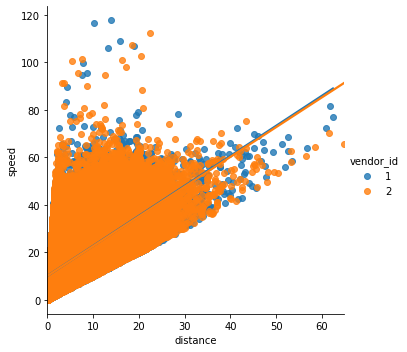

In [88]:
# line plot of distance vs speed 
sns.lmplot(x='distance', y='speed', hue='vendor_id', data = df_nyc_taxi)

There is a linear relation between distance and speed.

###**Going fast reduces the trip duration ?**

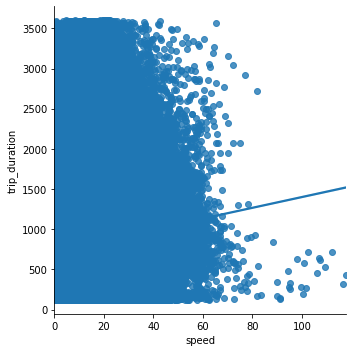

In [89]:
sns.lmplot(x='speed', y='trip_duration', data = df_nyc_taxi)

No, there is no relation between speed and trip_duration

###**Longer journeys take more time ?**

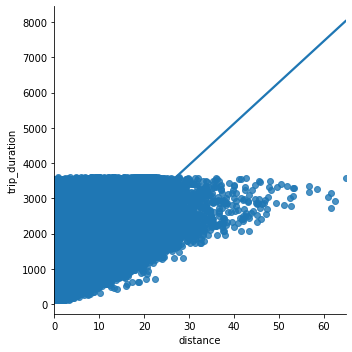

In [90]:
sns.lmplot(x='distance', y='trip_duration', data = df_nyc_taxi)

yes, there is a positive correlation between distance and duration

### **How many people share taxi trips ?**

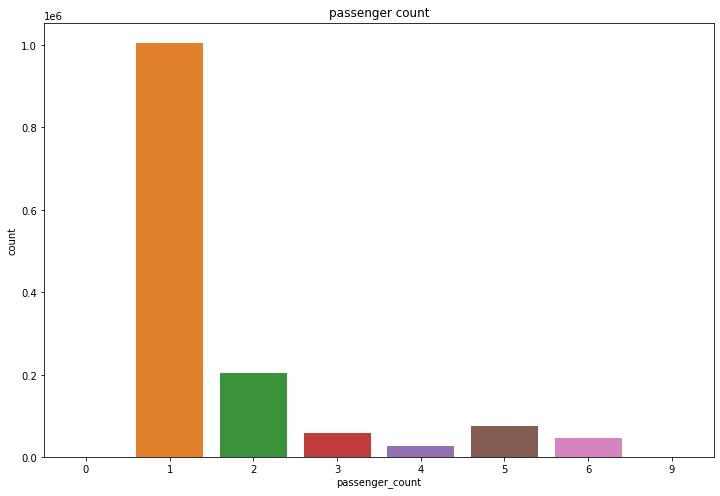

In [91]:
plt.figure(figsize=(12,8))
plt.title("passenger count")
sns.countplot(df_nyc_taxi.passenger_count)
plt.show()

**Maximum trips are with 1 passenger. Followed by 2, 5 and 3 passengers**

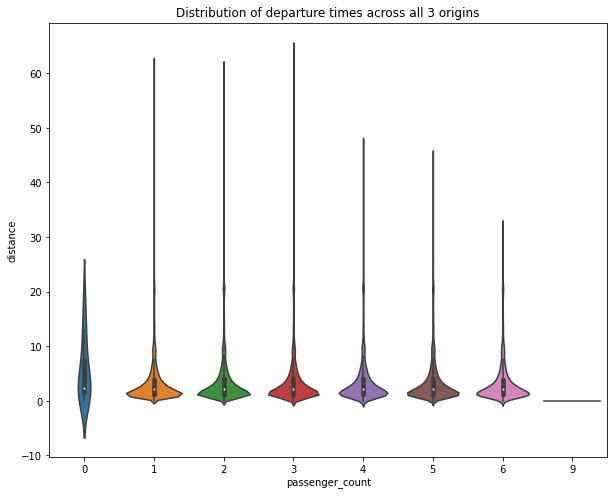

In [92]:
plt.figure(figsize=(10,8))
plt.title("Distribution of departure times across all 3 origins")
sns.violinplot(x='passenger_count', y='distance', data = df_nyc_taxi)
plt.show()

There are few trips with no passenger. This is strange ! May be the taxi has gone for a servicing or rest. Also having 9 passengers seems very rare and can be considered as outlier. So can be dropped.

#### **Drop samples having 9 and 0 passengers**

In [93]:
df_nyc_taxi.passenger_count.value_counts()

1    1003984
2     204808
5      76047
3      58440
6      47013
4      27650
0         13
9          1
Name: passenger_count, dtype: int64

In [0]:
df_nyc_taxi = df_nyc_taxi[(df_nyc_taxi['passenger_count'] != 0) & (df_nyc_taxi['passenger_count'] != 9)]

### **Lets see which hours (time slots) are busier**

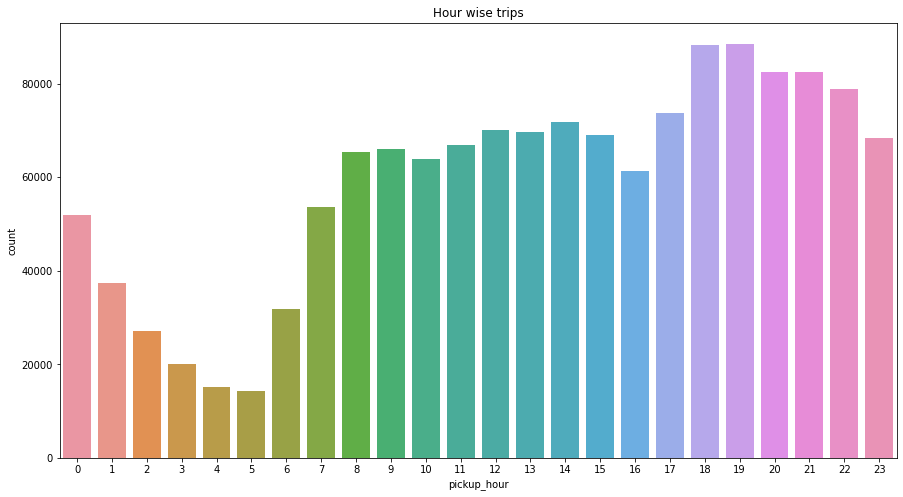

In [95]:
plt.figure(figsize=(15,8))
plt.title("Hour wise trips")
sns.countplot(x="pickup_hour", data=df_nyc_taxi)

As can be seen, the number of trips are **very low at 3AM, 4AM and 5AM and highest 6PM and 7PM**. Througout the day, there is an increasing trend from 7AM onwards till 7PM.<br>
**Since the trips are more, the overall traffic will also be more and hence will reduce the trip duration.**

**Hypothesis: 6PM, 7PM, 8PM, 9PM are peak times and 3AM, 4AM, 5AM are not !!** <br>
lets prove this.

To prove our hypothesis, we need to compare the average trip durations between 6PM, 7PM, 8PM, 9PM and 3AM, 4AM, 5AM (for known source and destinations)

Lets consider a particular source (lat, lon)= (40.76, -73.98) and destination (lat, lon)= (40.76, -73.96) and also distance = 1.4. This combination will be used to create a dataframe having the same souce and destinations. 

In [96]:
# create dataframe of a particular source and destination
df_nyc_taxi_evaltraffic = df_nyc_taxi[df_nyc_taxi.pickup_latitude.astype(str).str.startswith(r'40.76') 
                               & df_nyc_taxi.pickup_longitude.astype(str).str.startswith(r'-73.98')
                               & df_nyc_taxi.dropoff_latitude.astype(str).str.startswith(r'40.76') 
                               & df_nyc_taxi.dropoff_longitude.astype(str).str.startswith(r'-73.96')
                               & df_nyc_taxi.distance.astype(str).str.startswith(r'1.4')]


# average trip duration in minutes for trips between 6PM, 7PM, 8PM, 9PM
df_nyc_taxi_evaltraffic_evening = df_nyc_taxi_evaltraffic[df_nyc_taxi_evaltraffic.pickup_hour.isin([18, 19, 20, 21])]
print("average trip duration in minutes for trips between 6PM, 7PM, 8PM, 9PM:  ", df_nyc_taxi_evaltraffic_evening.trip_duration_minutes.mean())

# average trip duration in minutes for trips between 3AM, 4AM, 5AM
df_nyc_taxi_evaltraffic_morning = df_nyc_taxi_evaltraffic[df_nyc_taxi_evaltraffic.pickup_hour.isin([3, 4, 5])]
print("average trip duration in minutes for trips between 3AM, 4AM, 5AM:  ", df_nyc_taxi_evaltraffic_morning.trip_duration_minutes.mean())

average trip duration in minutes for trips between 6PM, 7PM, 8PM, 9PM:   9.91759259259259
average trip duration in minutes for trips between 3AM, 4AM, 5AM:   6.266666666666667


So, the mean trip_duration_minutes during time slots 6,7,8,9 PM is higher than at time slots 3,4,5 AM. <br>

Lets try this logic on another set of source and destination.

In [97]:
# create dataframe of a particular source and destination
df_nyc_taxi_evaltraffic1 = df_nyc_taxi[df_nyc_taxi.pickup_latitude.astype(str).str.startswith(r'40.71') 
                               & df_nyc_taxi.pickup_longitude.astype(str).str.startswith(r'-74.01')
                               & df_nyc_taxi.dropoff_latitude.astype(str).str.startswith(r'40.70') 
                               & df_nyc_taxi.dropoff_longitude.astype(str).str.startswith(r'-74.01')
                               & df_nyc_taxi.distance.astype(str).str.startswith(r'0.9')]

df_nyc_taxi_evaltraffic1
# average trip duration in minutes for trips between 6PM, 7PM, 8PM, 9PM
df_nyc_taxi_evaltraffic_evening1 = df_nyc_taxi_evaltraffic1[df_nyc_taxi_evaltraffic1.pickup_hour.isin([18, 19, 20, 21])]
print("average trip duration in minutes for trips between 6PM, 7PM, 8PM, 9PM:  ", df_nyc_taxi_evaltraffic_evening1.trip_duration_minutes.mean())

# average trip duration in minutes for trips between 3AM, 4AM, 5AM
df_nyc_taxi_evaltraffic_morning1 = df_nyc_taxi_evaltraffic1[df_nyc_taxi_evaltraffic1.pickup_hour.isin([3, 4, 5])]
print("average trip duration in minutes for trips between 3AM, 4AM, 5AM:  ", df_nyc_taxi_evaltraffic_morning1.trip_duration_minutes.mean())

average trip duration in minutes for trips between 6PM, 7PM, 8PM, 9PM:   6.441071428571428
average trip duration in minutes for trips between 3AM, 4AM, 5AM:   3.133333333333333


**Hence, proved that times 6,7,8,9 PM are peak times and times 3,4,5 AM is non peak times !!!**

#### **Now, lets see which days of the week are more busy!**

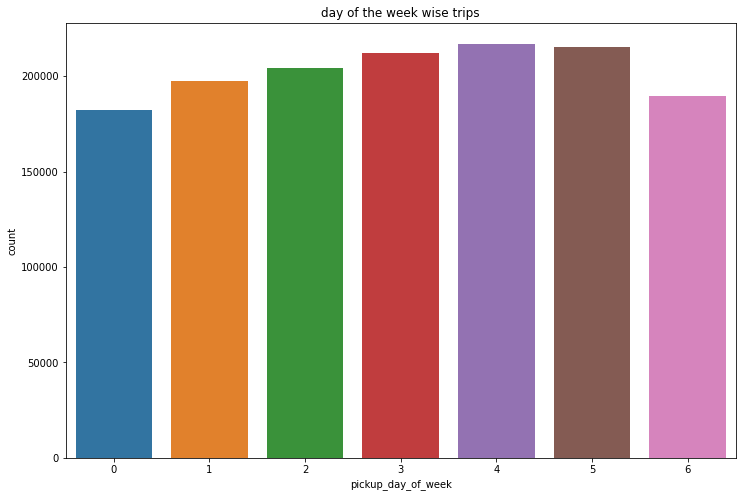

In [98]:
plt.figure(figsize=(12,8))
plt.title("day of the week wise trips")
sns.countplot(x="pickup_day_of_week", data=df_nyc_taxi)

**Friday, Saturday** are seen to have more trips compared to other days of the week. Whereas **Monday, Sunday** have the lowest

**Hence we can come to a conclusion that On Friday, Saturday betweeen 6,7,8,9 PM the traffic will be even more.**

### **Lets see which months are busier**

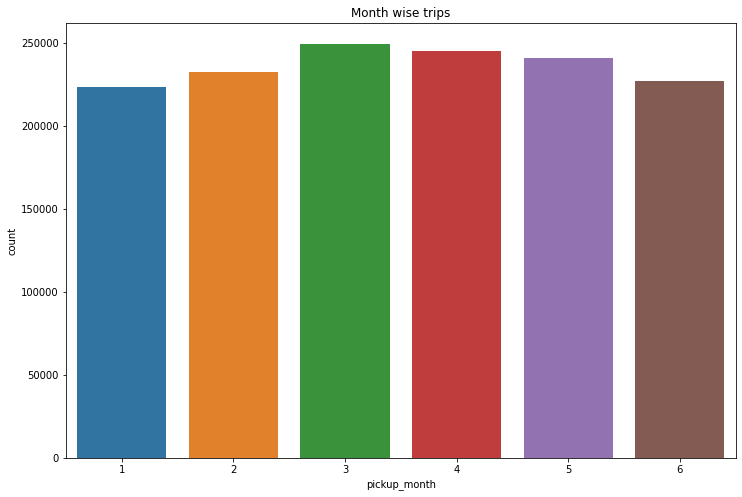

In [99]:
plt.figure(figsize=(12,8))
plt.title("Month wise trips")
sns.countplot(x="pickup_month", data=df_nyc_taxi)

the dataset contains trips for only 6 months. **March** has the highest number of trips followed by April and May. This feature follows a normal distribution

### **Whats with the 'store_and_fwd_flag' feature ?**

In [100]:
df_nyc_taxi.store_and_fwd_flag.value_counts()

N    1410318
Y       7624
Name: store_and_fwd_flag, dtype: int64

This feature is very imbalanced.

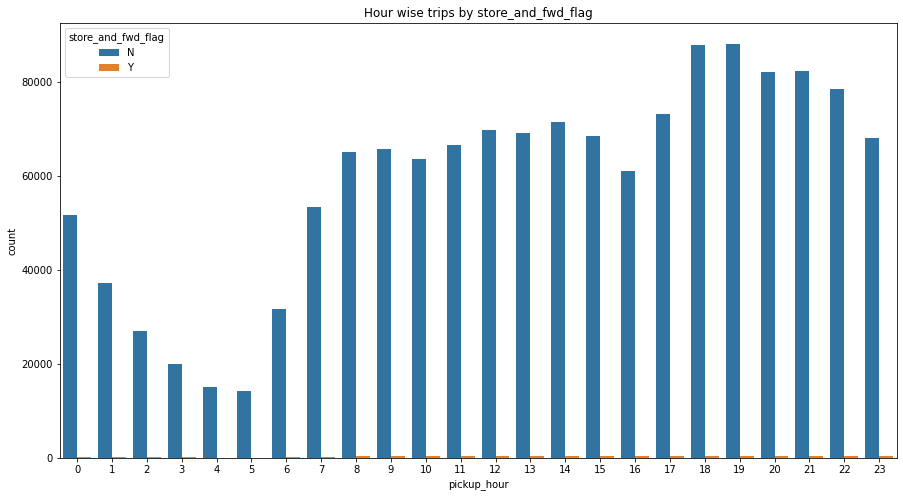

In [101]:
plt.figure(figsize=(15,8))
plt.title("Hour wise trips by store_and_fwd_flag")
sns.countplot(x="pickup_hour", hue ="store_and_fwd_flag", data=df_nyc_taxi)

This feature can be dropped as it does not add any information

In [0]:
df_nyc_taxi = df_nyc_taxi.drop(columns='store_and_fwd_flag')

### **What is the average distance travelled and speed per weekday ?**

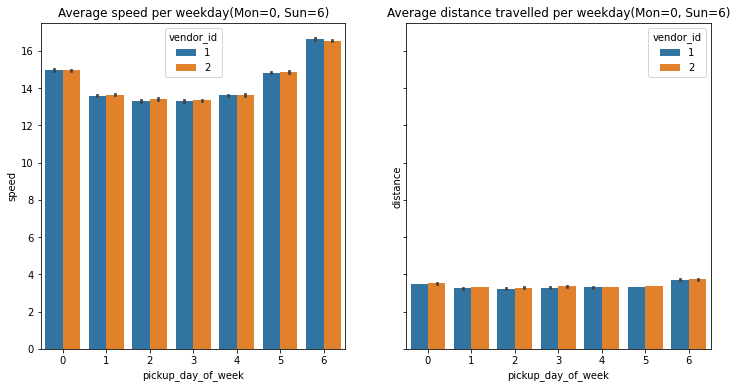

In [103]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,6))
ax1.set_title("Average speed per weekday(Mon=0, Sun=6)", fontsize=12)
ax2.set_title("Average distance travelled per weekday(Mon=0, Sun=6)", fontsize=12)
sns.barplot(x="pickup_day_of_week", y="speed", hue="vendor_id", data=df_nyc_taxi, ax=ax1)
sns.barplot(x="pickup_day_of_week", y="distance", hue="vendor_id", data=df_nyc_taxi, ax=ax2)



On **Sundays, the average speed and distance travelled is high compared to other days of the week**

### **What is the average distance travelled and speed per hour ?**

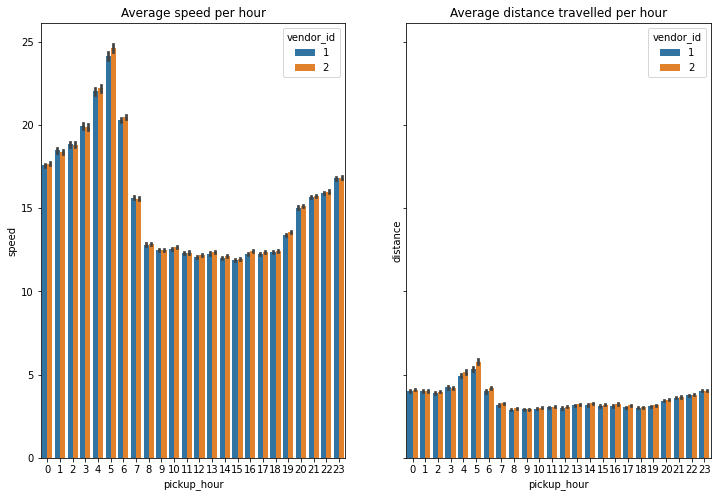

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,8))
ax1.set_title("Average speed per hour", fontsize=12)
ax2.set_title("Average distance travelled per hour", fontsize=12)
sns.barplot(x="pickup_hour", y="speed", hue="vendor_id", data=df_nyc_taxi, ax=ax1)
sns.barplot(x="pickup_hour", y="distance", hue="vendor_id", data=df_nyc_taxi, ax=ax2)

**The average speed is pretty high at 4, 5 AM and steady from 8 AM till 6PM. And goes high from 7PM till 11 PM** <br>

**Also the average travel distance increases at 4, 5 AM**

### **Does the vendor_id play any role ?**

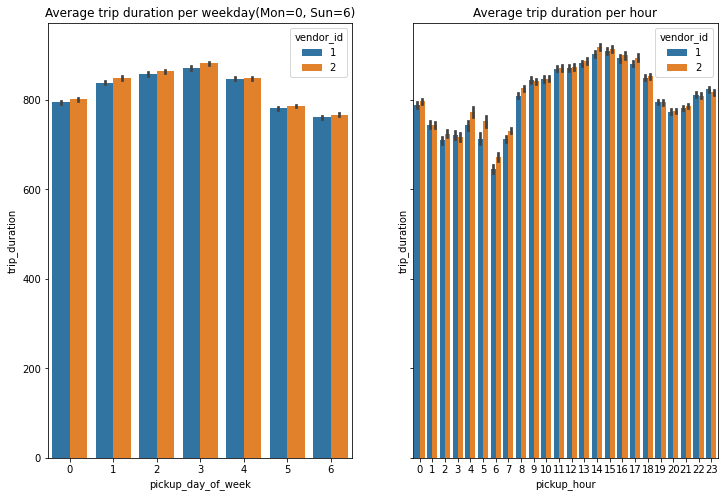

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,8))
ax1.set_title("Average trip duration per weekday(Mon=0, Sun=6)", fontsize=12)
ax2.set_title("Average trip duration per hour", fontsize=12)
sns.barplot(x="pickup_day_of_week", y="trip_duration", hue="vendor_id", data=df_nyc_taxi, ax=ax1)
sns.barplot(x="pickup_hour", y="trip_duration", hue="vendor_id", data=df_nyc_taxi, ax=ax2)

The vendor_id doesnt seem to play any role in deciding the trip duration as it doesnt have any linear relation with speed, distance, trip_duration. **Hence, we can drop 'vendor_id'**

### **Drop 'vendor_id' feature'**

In [0]:
df_nyc_taxi = df_nyc_taxi.drop(columns='vendor_id')

### **Drop 'pickup_datetime' and 'dropoff_datetime' columns**

In [0]:
df_nyc_taxi = df_nyc_taxi.drop(columns=['pickup_datetime', 'dropoff_datetime'])

### **Lets add a new feature which indicates traffic (high(2), low(0), medium(1))**

In [0]:
#col         = 'pickup_hour'
#conditions  = [ df_nyc_taxi[col].isin([18, 19, 20, 21, 22]), 
 #              df_nyc_taxi[col].isin([0, 7, 8, 9, 10, 11, 12 , 13, 14, 15, 16, 17, 23]), 
 #              df_nyc_taxi[col].isin([1, 2, 3, 4, 5, 6]) ]
#choices     = [ 2, 1, 0]

#df_nyc_taxi['traffic'] = np.select(conditions, choices) 

In [0]:
col         = 'pickup_hour'
conditions  = [df_nyc_taxi[col].isin([18, 19, 20, 21, 22, 8, 9, 10, 11, 12 , 13, 14, 15, 16, 17, 23]), 
               df_nyc_taxi[col].isin([0, 1, 2, 3, 4, 5, 6, 7]) ]
choices     = [1, 0]
df_nyc_taxi['traffic'] = np.select(conditions, choices) 

In [110]:
df_nyc_taxi.head()

,id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,trip_duration_minutes,distance,speed,pickup_month,pickup_day,pickup_hour,pickup_day_of_week,drop_month,drop_day,drop_hour,drop_day_of_week,traffic
0,id2875421,1,-73.982155,40.767937,-73.964630,40.765602,455,7.583333,1.498521,11.856428,3,14,17,0,3,14,14,0,1
1,id2377394,1,-73.980415,40.738564,-73.999481,40.731152,663,11.050000,1.805507,9.803659,6,12,0,6,6,12,12,6,0
2,id3858529,1,-73.979027,40.763939,-74.005333,40.710087,2124,35.400000,6.385098,10.822201,1,19,11,1,1,19,19,1,1
3,id3504673,1,-74.010040,40.719971,-74.012268,40.706718,429,7.150000,1.485498,12.465721,4,6,19,2,4,6,6,2,1
4,id2181028,1,-73.973053,40.793209,-73.972923,40.782520,435,7.250000,1.188588,9.836594,3,26,13,5,3,26,26,5,1


In [111]:
df_nyc_taxi.shape

(1417942, 19)

### **Relation between traffic and trip duration**

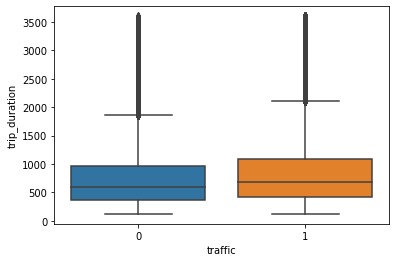

In [112]:
sns.boxplot(x='traffic', y = 'trip_duration', data=df_nyc_taxi)

As traffic increases, the trip duration increases

### **Drop samples having idle state**

In [23]:
df_nyc_taxi[(df_nyc_taxi.speed < 1)&(df_nyc_taxi.distance == 0)]

,id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,trip_duration_minutes,distance,speed,pickup_month,pickup_day,pickup_hour,pickup_day_of_week,drop_month,drop_day,drop_hour,drop_day_of_week,traffic
246,id3487442,1,-73.981819,40.768963,-73.981819,40.768963,227,3.783333,0.0,0.0,2,29,18,0,2,29,29,0,1
291,id0924324,2,-73.959068,40.775661,-73.959068,40.775661,1109,18.483333,0.0,0.0,5,10,18,1,5,10,10,1,1
407,id1145809,6,-73.808487,40.687336,-73.808487,40.687336,947,15.783333,0.0,0.0,5,16,23,0,5,16,16,0,1
702,id3499387,1,-73.786720,40.647041,-73.786720,40.647041,580,9.666667,0.0,0.0,1,25,19,0,1,25,25,0,1
1769,id2892749,5,-73.954666,40.821003,-73.954666,40.821003,254,4.233333,0.0,0.0,1,18,15,0,1,18,18,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456399,id0618137,1,-73.978859,40.756721,-73.978859,40.756721,1284,21.400000,0.0,0.0,2,17,8,2,2,17,17,2,1
1456627,id1048767,1,-73.963554,40.768517,-73.963554,40.768517,127,2.116667,0.0,0.0,2,6,22,5,2,6,6,5,1
1456989,id2595295,1,-73.984848,40.728222,-73.984848,40.728222,566,9.433333,0.0,0.0,3,12,7,5,3,12,12,5,0
1457114,id0051314,1,-73.965981,40.770988,-73.965981,40.770988,632,10.533333,0.0,0.0,4,9,20,5,4,9,9,5,1


In [0]:
temp1 = df_nyc_taxi[(df_nyc_taxi.speed < 1)&(df_nyc_taxi.distance == 0)]
df_nyc_taxi.drop(temp1.index,inplace=True)

### **Lets find days having very high traffic (accidents, road works, events etc)**

In [115]:
df_nyc_taxi[(df_nyc_taxi.speed < 3)]

,id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,trip_duration_minutes,distance,speed,pickup_month,pickup_day,pickup_hour,pickup_day_of_week,drop_month,drop_day,drop_hour,drop_day_of_week,traffic
251,id0171820,1,-74.004524,40.724194,-74.004494,40.724667,189,3.150000,0.052661,1.003058,5,25,6,2,5,25,25,2,0
337,id0790613,1,-73.986305,40.777023,-73.985855,40.776791,1778,29.633333,0.045892,0.092921,5,20,14,4,5,20,20,4,1
391,id3385889,1,-73.972687,40.755863,-73.977333,40.758675,940,15.666667,0.500883,1.918275,2,12,9,4,2,12,12,4,1
552,id0131920,1,-73.996605,40.725510,-73.996239,40.725796,1905,31.750000,0.044322,0.083757,2,13,17,5,2,13,13,5,1
727,id3480123,1,-73.986916,40.758820,-73.973022,40.764877,1679,27.983333,1.350143,2.894886,1,26,17,1,1,26,26,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458065,id1268819,2,-73.991913,40.754131,-73.977341,40.750050,2055,34.250000,1.308703,2.292619,6,28,17,1,6,28,28,1,1
1458166,id0429463,1,-73.974388,40.742908,-73.980751,40.744438,1058,17.633333,0.562386,1.913600,4,22,8,4,4,22,22,4,1
1458228,id3175933,1,-74.000938,40.724171,-73.999268,40.721600,602,10.033333,0.318687,1.905768,1,30,17,5,1,30,30,5,1
1458291,id0078326,1,-73.936874,40.764610,-73.936768,40.764694,318,5.300000,0.012962,0.146735,5,4,1,2,5,4,4,2,0


These 13456 rows are outliers and we can drop them

In [0]:
temp1 = df_nyc_taxi[(df_nyc_taxi.speed < 3)]
df_nyc_taxi.drop(temp1.index,inplace=True)

### **Drop very very short trip**

In [0]:
# select trips having distance of less than 150 meters
temp1 = df_nyc_taxi[df_nyc_taxi['distance']< .15]
df_nyc_taxi.drop(temp1.index,inplace=True)

In [118]:
df_nyc_taxi.shape

(1400449, 19)

### **There are many trips ending on the next day. Lets drop them**

In [28]:
df_nyc_taxi[df_nyc_taxi.pickup_day < df_nyc_taxi.drop_day]

,id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,trip_duration_minutes,distance,speed,pickup_month,pickup_day,pickup_hour,pickup_day_of_week,drop_month,drop_day,drop_hour,drop_day_of_week,traffic
86,id0283075,1,-73.782478,40.644646,-73.981125,40.720886,1782,29.700000,18.773486,37.926235,4,6,23,2,4,7,7,3,1
607,id3885431,2,-73.788261,40.647362,-74.007446,40.577190,1733,28.883333,20.079753,41.712124,3,2,23,2,3,3,3,3,1
615,id1074936,1,-73.971924,40.747356,-73.979996,40.733524,318,5.300000,1.681695,19.038052,5,29,23,6,5,30,30,0,1
722,id2704068,1,-73.972359,40.765221,-73.955238,40.720089,1563,26.050000,5.221571,12.026652,3,5,23,5,3,6,6,6,1
871,id2448137,1,-74.007553,40.740822,-73.987282,40.750740,681,11.350000,2.032870,10.746451,3,11,23,4,3,12,12,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458121,id2225868,5,-74.000458,40.747791,-73.945961,40.704231,1725,28.750000,6.674608,13.929616,4,16,23,5,4,17,17,6,1
1458373,id0507671,1,-73.789841,40.646820,-74.008186,40.707844,2147,35.783333,19.623452,32.903785,1,3,23,6,1,4,4,0,1
1458434,id1802125,2,-73.986221,40.737759,-73.964905,40.753883,515,8.583333,2.537630,17.738770,5,2,23,0,5,3,3,1,1
1458445,id3860980,1,-73.971542,40.757721,-73.991043,40.750568,647,10.783333,1.825005,10.154587,3,11,23,4,3,12,12,5,1


In [0]:
temp1 = df_nyc_taxi[df_nyc_taxi.pickup_day < df_nyc_taxi.drop_day]
df_nyc_taxi.drop(temp1.index,inplace=True)

## **Train models on dataset**

#### **Import ML libraries**

In [0]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

### **Run Linear regression model**

In [0]:
# define a function that accepts a list of features and returns testing RMSE
def train_test_rmse(feature_cols):
    #X1 = preprocessing.scale(df_nyc_taxi)
    #X = pd.DataFrame(X2)
    #y = preprocessing.scale(nyc_taxi_new['trip_duration'])
    X = df_nyc_taxi[feature_cols]
    y = df_nyc_taxi.trip_duration
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    print(list(zip(feature_cols, linreg.coef_)))
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [123]:
df_nyc_taxi.columns

Index(['id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration',
       'trip_duration_minutes', 'distance', 'speed', 'pickup_month',
       'pickup_day', 'pickup_hour', 'pickup_day_of_week', 'drop_month',
       'drop_day', 'drop_hour', 'drop_day_of_week', 'traffic'],
      dtype='object')

In [124]:
# compare different sets of features
print (train_test_rmse(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude',
       'trip_duration_minutes', 'distance', 'speed', 'pickup_month',
       'pickup_day', 'pickup_hour', 'pickup_day_of_week', 'drop_month',
       'drop_day', 'drop_hour', 'drop_day_of_week', 'traffic']))

print (train_test_rmse(['distance', 'speed', 'pickup_month',
       'pickup_day', 'pickup_hour', 'pickup_day_of_week', 'drop_month',
       'drop_day', 'drop_hour', 'drop_day_of_week', 'traffic']))

print (train_test_rmse(['distance', 'speed', 'pickup_hour', 'pickup_day_of_week', 'traffic']))

print (train_test_rmse(['distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','speed', 'pickup_day_of_week', 'traffic', 'pickup_month',
       'pickup_day', 'pickup_hour']))

print (train_test_rmse(['distance', 'traffic']))

[('passenger_count', -2.0105821404116232e-14), ('pickup_longitude', 8.65441052155802e-12), ('pickup_latitude', 1.8804141464619737e-12), ('dropoff_longitude', -1.0965422924092721e-12), ('dropoff_latitude', -1.869229869271583e-12), ('trip_duration_minutes', 60.00000000000007), ('distance', 3.044770553313244e-14), ('speed', -8.938461903408769e-15), ('pickup_month', -4.60443716151669e-13), ('pickup_day', -4.6257208168046956e-14), ('pickup_hour', 3.387370892945626e-15), ('pickup_day_of_week', 1.1968363603167895e-14), ('drop_month', 4.540115234397841e-13), ('drop_day', -1.1119509340800657e-14), ('drop_hour', -1.2007687760500782e-14), ('drop_day_of_week', -6.140897851815122e-15), ('traffic', -1.502336059303451e-15)]
1.1113777724786307e-12
[('distance', 175.5557002878438), ('speed', -45.846833275671564), ('pickup_month', -2101.973980842904), ('pickup_day', -71.31877029310067), ('pickup_hour', -2.344739012061831), ('pickup_day_of_week', -23.73443800516929), ('drop_month', 2110.2897524345367), (

258.30213334032675    
257.21922311340944

253.07953623078615

252.68421195526906

250.39354652237776

250.10883764986087

### **Calculate null RMSE**

In [125]:
# compute null RMSE
feature_cols = ['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude',
       'distance', 'speed', 'pickup_month',
       'pickup_day', 'pickup_hour', 'pickup_day_of_week', 'drop_month',
       'drop_day', 'drop_hour', 'drop_day_of_week', 'traffic']
X = df_nyc_taxi[feature_cols]
y = df_nyc_taxi.trip_duration
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)

# fill the array with the mean value of y_test
y_null.fill(y_test.mean())
y_null
np.sqrt(metrics.mean_squared_error(y_test, y_null))

578.8483290559001

The RMSE values for our linear regression model is way less than the null RMSE

**Our dataset has very less features which have a relation with the output columns. Also, the 'speed' feature is correlated to the 'distance' feature.**

### **Encoding and scaling features**

Most of the columns are categorical. Lets consider one by one and dummy encode the unordered features

In [0]:
# hour as a categorical feature
hour_dummies = pd.get_dummies(df_nyc_taxi.pickup_hour, prefix='p_hour')
hour_dummies.drop(hour_dummies.columns[0], axis=1, inplace=True)
df_nyc_taxi = pd.concat([df_nyc_taxi, hour_dummies], axis=1)

In [0]:
# month as a categorical feature
month_dummies = pd.get_dummies(df_nyc_taxi.pickup_month, prefix='p_month')
month_dummies.drop(month_dummies.columns[0], axis=1, inplace=True)
df_nyc_taxi = pd.concat([df_nyc_taxi, month_dummies], axis=1)

In [0]:
# day as a categorical feature
day_dummies = pd.get_dummies(df_nyc_taxi.pickup_day, prefix='p_day')
day_dummies.drop(day_dummies.columns[0], axis=1, inplace=True)
df_nyc_taxi = pd.concat([df_nyc_taxi, day_dummies], axis=1)

In [0]:
# day_of_week as a categorical feature
day_of_week_dummies = pd.get_dummies(df_nyc_taxi.pickup_day_of_week, prefix='p_dow')
day_of_week_dummies.drop(day_of_week_dummies.columns[0], axis=1, inplace=True)
df_nyc_taxi = pd.concat([df_nyc_taxi, day_of_week_dummies], axis=1)

In [32]:
df_nyc_taxi.columns

Index(['id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration',
       'trip_duration_minutes', 'distance', 'speed', 'pickup_month',
       'pickup_day', 'pickup_hour', 'pickup_day_of_week', 'drop_month',
       'drop_day', 'drop_hour', 'drop_day_of_week', 'traffic', 'p_hour_1',
       'p_hour_2', 'p_hour_3', 'p_hour_4', 'p_hour_5', 'p_hour_6', 'p_hour_7',
       'p_hour_8', 'p_hour_9', 'p_hour_10', 'p_hour_11', 'p_hour_12',
       'p_hour_13', 'p_hour_14', 'p_hour_15', 'p_hour_16', 'p_hour_17',
       'p_hour_18', 'p_hour_19', 'p_hour_20', 'p_hour_21', 'p_hour_22',
       'p_hour_23', 'p_month_2', 'p_month_3', 'p_month_4', 'p_month_5',
       'p_month_6', 'p_day_2', 'p_day_3', 'p_day_4', 'p_day_5', 'p_day_6',
       'p_day_7', 'p_day_8', 'p_day_9', 'p_day_10', 'p_day_11', 'p_day_12',
       'p_day_13', 'p_day_14', 'p_day_15', 'p_day_16', 'p_day_17', 'p_day_18',
       'p_day_19', 'p_day_20', 'p_day_21', 'p_day_22'

In [0]:
# scaling features using standardization
df_nyc_taxi_copy = df_nyc_taxi.copy()
df_nyc_taxi_scale=df_nyc_taxi_copy.drop(['id','passenger_count','trip_duration','trip_duration_minutes',
                      'pickup_month','pickup_day','pickup_hour','pickup_day_of_week',
                      'drop_month', 'drop_day','drop_hour','drop_day_of_week'],axis=1)
X1=preprocessing.scale(df_nyc_taxi_scale)
X=pd.DataFrame(X1)
y=preprocessing.scale(df_nyc_taxi['trip_duration'])

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print(list(zip(feature_cols, linreg.coef_)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

[('passenger_count', -0.06241406753451764), ('pickup_longitude', 0.06210358248358194), ('pickup_latitude', -0.024828392813631583), ('dropoff_longitude', -0.005504112027434949), ('dropoff_latitude', 1.1809228738670439), ('distance', -0.5865220791509098), ('speed', 967255890044.0951), ('pickup_month', -0.00029153641291601584), ('pickup_day', 0.0006353401045122789), ('pickup_hour', 0.0017369304395528917), ('pickup_day_of_week', -0.0012739869811814672), ('drop_month', -0.004085519523326028), ('drop_day', -0.005024641625772618), ('drop_hour', -0.009078043253656305), ('drop_day_of_week', -530482606303.57965), ('traffic', -533089731986.24835)]
0.4315159666625031


**After standardizing the data, the RMSE value is 0.4315159666625031**

In [179]:
# calculate null rmse
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)

# fill the array with the mean value of y_test
y_null.fill(y_test.mean())
y_null
np.sqrt(metrics.mean_squared_error(y_test, y_null))

1.0013811203489507

**And, RMSE (0.43414087493454934) is greater than null RMSE of 1.000325562549815**

### **Explain model using LIME**

Intercept -25541749459390.65
Prediction_local [-1.19915099e+12]
Right: 0.9170931868237918


,0,1
0,p_hour_19 <= -0.26,2.614678e+12
1,p_hour_16 <= -0.21,2.598127e+12
2,p_hour_23 <= -0.20,2.542595e+12
3,p_hour_13 <= -0.23,2.458166e+12
4,p_hour_9 <= -0.22,2.453980e+12
5,p_hour_8 <= -0.22,2.394090e+12
6,p_hour_18 <= -0.26,2.363674e+12
7,p_hour_12 <= -0.23,2.318261e+12
8,p_hour_17 <= -0.23,2.311974e+12
9,p_hour_14 <= -0.23,2.287054e+12


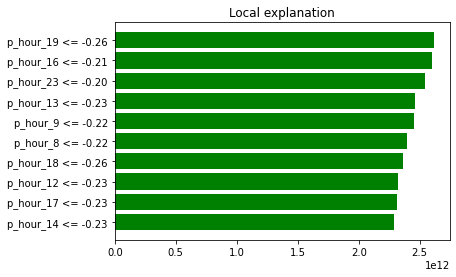

In [187]:
np.random.seed(0)
import lime
import lime.lime_tabular

explainer1 = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),feature_names=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'distance', 'speed', 'traffic', 'p_hour_1',
       'p_hour_2', 'p_hour_3', 'p_hour_4', 'p_hour_5', 'p_hour_6', 'p_hour_7',
       'p_hour_8', 'p_hour_9', 'p_hour_10', 'p_hour_11', 'p_hour_12',
       'p_hour_13', 'p_hour_14', 'p_hour_15', 'p_hour_16', 'p_hour_17',
       'p_hour_18', 'p_hour_19', 'p_hour_20', 'p_hour_21', 'p_hour_22',
       'p_hour_23', 'p_month_2', 'p_month_3', 'p_month_4', 'p_month_5',
       'p_month_6', 'p_day_2', 'p_day_3', 'p_day_4', 'p_day_5', 'p_day_6',
       'p_day_7', 'p_day_8', 'p_day_9', 'p_day_10', 'p_day_11', 'p_day_12',
       'p_day_13', 'p_day_14', 'p_day_15', 'p_day_16', 'p_day_17', 'p_day_18',
       'p_day_19', 'p_day_20', 'p_day_21', 'p_day_22', 'p_day_23', 'p_day_24',
       'p_day_25', 'p_day_26', 'p_day_27', 'p_day_28', 'p_day_29', 'p_day_30',
       'p_day_31', 'p_dow_1', 'p_dow_2', 'p_dow_3', 'p_dow_4', 'p_dow_5',
       'p_dow_6'], 
        verbose=True, mode='regression')

exp = explainer1.explain_instance(X_test.iloc[200], linreg.predict)
exp.as_pyplot_figure()
pd.DataFrame(exp.as_list())

**Explanation:**<br>
1) p_hour_19, p_hour_16, p_hour_23, p_hour_13,p_hour_8, p_hour_8 features have a very positive relation with the output. <br>
2) distance has a positive relation with output <br>
3) speed also has a positive relation <br>
4) All features in green have a positive relation whereas all orange features have a negative feature

### **Run Decision tree**

In [0]:
from sklearn.tree import DecisionTreeRegressor

In [0]:
df_nyc_taxi_copy = df_nyc_taxi.copy()
df_nyc_taxi_scale=df_nyc_taxi_copy.drop(['id','passenger_count','trip_duration','trip_duration_minutes',
                      'pickup_month','pickup_day','pickup_hour','pickup_day_of_week',
                      'drop_month', 'drop_day','drop_hour','drop_day_of_week'],axis=1)
X1=preprocessing.scale(df_nyc_taxi_scale)
X=pd.DataFrame(X1)
y=preprocessing.scale(df_nyc_taxi['trip_duration'])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [0]:
dt.fit(X_train, y_train)                                         
y_pred = dt.predict(X_test)  

In [191]:
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.058672099499114956


**The RMSE using decision tree is 0.05867209949911495**

## **XGBoost**

In [174]:
df_nyc_taxi.columns

Index(['id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration',
       'trip_duration_minutes', 'distance', 'speed', 'pickup_month',
       'pickup_day', 'pickup_hour', 'pickup_day_of_week', 'drop_month',
       'drop_day', 'drop_hour', 'drop_day_of_week', 'traffic', 'p_hour_1',
       'p_hour_2', 'p_hour_3', 'p_hour_4', 'p_hour_5', 'p_hour_6', 'p_hour_7',
       'p_hour_8', 'p_hour_9', 'p_hour_10', 'p_hour_11', 'p_hour_12',
       'p_hour_13', 'p_hour_14', 'p_hour_15', 'p_hour_16', 'p_hour_17',
       'p_hour_18', 'p_hour_19', 'p_hour_20', 'p_hour_21', 'p_hour_22',
       'p_hour_23', 'p_month_2', 'p_month_3', 'p_month_4', 'p_month_5',
       'p_month_6', 'p_day_2', 'p_day_3', 'p_day_4', 'p_day_5', 'p_day_6',
       'p_day_7', 'p_day_8', 'p_day_9', 'p_day_10', 'p_day_11', 'p_day_12',
       'p_day_13', 'p_day_14', 'p_day_15', 'p_day_16', 'p_day_17', 'p_day_18',
       'p_day_19', 'p_day_20', 'p_day_21', 'p_day_22'

In [0]:
df_nyc_taxi_copy = df_nyc_taxi.copy()

In [176]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import RandomizedSearchCV , cross_val_score, KFold

X2=df_nyc_taxi_copy.drop(['id','passenger_count','trip_duration','trip_duration_minutes',
                      'pickup_month','pickup_day','pickup_hour','pickup_day_of_week',
                      'drop_month', 'drop_day','drop_hour','drop_day_of_week'],axis=1)
X1=preprocessing.scale(X2)
X=pd.DataFrame(X1)
y=preprocessing.scale(df_nyc_taxi['trip_duration'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)

model = xgb.XGBRegressor()
model.fit(X_train,y_train)

y_pred = model.predict(data=X_test)

rmse= np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Root Mean Squared Error:',rmse )


[16:12:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Root Mean Squared Error: 0.0645947533024637


**Root Mean Squared Error: 0.0645947533024637**

### **Stacking**

In [0]:
# Importing Models
from sklearn import svm, tree, linear_model, neighbors, ensemble, discriminant_analysis, gaussian_process
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC, LinearSVC
import xgboost as xgb

# Importing other tools
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [0]:
# Defining random seed
seed=42

# Creating Models

lr = LinearRegression()
lda = LinearDiscriminantAnalysis()
dtree = DecisionTreeRegressor(random_state=seed)
rf = RandomForestRegressor(10, random_state=seed)
gdb = GradientBoostingRegressor(random_state=seed)
adb = AdaBoostRegressor(random_state=seed)
#xgb = XGBClassifier(random_state=seed)

first_models = [ lr, lda, dtree, 
                 rf, gdb, adb]
first_model_names = ['Logistic Regression','LDA','Decision Tree', 
                     'Random Forest', 'GradientBoosting',
                    'AdaBoost'] 

# Defining other steps
n_folds = 5
skf = model_selection.ShuffleSplit(n_splits = n_folds, test_size = .3, train_size = .6, random_state = seed ) 
std_sca = StandardScaler()

In [0]:
X2=df_nyc_taxi_copy.drop(['id','passenger_count','trip_duration','trip_duration_minutes',
                      'pickup_month','pickup_day','pickup_hour','pickup_day_of_week',
                      'drop_month', 'drop_day','drop_hour','drop_day_of_week'],axis=1)
X1=preprocessing.scale(X2)
X=pd.DataFrame(X1)
y=preprocessing.scale(df_nyc_taxi['trip_duration'])

In [0]:
X2=df_nyc_taxi_copy.drop(['id','passenger_count','trip_duration','trip_duration_minutes',
                      'pickup_month','pickup_day','pickup_hour','pickup_day_of_week',
                      'drop_month', 'drop_day','drop_hour','drop_day_of_week'],axis=1)
#X1=preprocessing.scale(X2)
X=pd.DataFrame(X2)
y=df_nyc_taxi['trip_duration']

### **Initial Model building**

In [0]:
MLA_columns = ['MLA Name', 'MLA Parameters','MLA RMSE']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = df_nyc_taxi[['id']]

train_size = X.shape[0]
n_models = len(first_models)
oof_pred = np.zeros((train_size, n_models))
scores = []
row_index=0

for n, model in enumerate(first_models):
    model_pipeline = Pipeline(steps=[('Scaler', std_sca),
                                     ('Estimator', model)])
    MLA_name = model.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(model.get_params())
    
    #cv_results = model_selection.cross_validate(model, X, y, cv  = skf, scoring='mean_squared_error')
    cv_results = cross_val_score(model, X, y, cv  = skf, scoring='neg_root_mean_squared_error') 

    print(cv_results)
    #MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA RMSE'] = mean(cv_results)
    #MLA_compare.loc[row_index, 'MLA Test RMSE'] = cv_results['test_score'].mean()  
    
    model_pipeline.fit(X, y)
    MLA_predict[MLA_name] = model_pipeline.predict(X)
    row_index+=1
        

[-248.46540196 -248.27171952 -249.22696368 -249.35390327 -248.57720731]


**The above pipeline crashes**

In [0]:
# compare machine learning models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot
 
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X2=df_nyc_taxi_copy.drop(['id','passenger_count','trip_duration','trip_duration_minutes',                           
                            'pickup_month','pickup_day','pickup_hour','pickup_day_of_week',
                            'drop_month', 'drop_day','drop_hour','drop_day_of_week'],axis=1)
X=pd.DataFrame(X2)
y=df_nyc_taxi['trip_duration']
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
#pyplot.boxplot(results, labels=names, showmeans=True)
#pyplot.show()

>knn -2.271 (0.008)


In [1]:
query_result = {
    "SiteErp": ["1"],
    "EAN13": ["2345678901236"],
    "DUN14": ["12345678901236"],
    "ErpKey": ["57"],
    "SiteID": ["10"]
    }
res = dict((key, val[0]) for (key, val) in query_result.items())
res

{'DUN14': '12345678901236',
 'EAN13': '2345678901236',
 'ErpKey': '57',
 'SiteErp': '1',
 'SiteID': '10'}